In [1]:
#Importing Packages
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sklearn.preprocessing as pre
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
import torch.nn.functional as F

import os
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder

In [2]:
#Move to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# #Importing data from UNSW_NB15
# train_df = pd.read_csv('data/UNSW_NB15_training-set.csv')
# test_df = pd.read_csv('data/UNSW_NB15_testing-set.csv')
# https://www.kaggle.com/datasets/samayashar/fraud-detection-transactions-dataset
df = pd.read_csv('data/synthetic_fraud_dataset.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [4]:
object_cols = ['Transaction_Type', 'Timestamp', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type', 'Authentication_Method']

# Initialize LabelEncoder
le = LabelEncoder()

# Apply Label Encoding to each object column
for col in object_cols:
    df[col] = le.fit_transform(df[col])

train_df, test_df = tts(df, test_size=0.2)

train_df, val_df = tts(train_df, test_size=0.25)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 7652 to 42002
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                30000 non-null  object 
 1   User_ID                       30000 non-null  object 
 2   Transaction_Amount            30000 non-null  float64
 3   Transaction_Type              30000 non-null  int64  
 4   Timestamp                     30000 non-null  int64  
 5   Account_Balance               30000 non-null  float64
 6   Device_Type                   30000 non-null  int64  
 7   Location                      30000 non-null  int64  
 8   Merchant_Category             30000 non-null  int64  
 9   IP_Address_Flag               30000 non-null  int64  
 10  Previous_Fraudulent_Activity  30000 non-null  int64  
 11  Daily_Transaction_Count       30000 non-null  int64  
 12  Avg_Transaction_Amount_7d     30000 non-null  float64
 13  Fai

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15858 to 1603
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                10000 non-null  object 
 1   User_ID                       10000 non-null  object 
 2   Transaction_Amount            10000 non-null  float64
 3   Transaction_Type              10000 non-null  int64  
 4   Timestamp                     10000 non-null  int64  
 5   Account_Balance               10000 non-null  float64
 6   Device_Type                   10000 non-null  int64  
 7   Location                      10000 non-null  int64  
 8   Merchant_Category             10000 non-null  int64  
 9   IP_Address_Flag               10000 non-null  int64  
 10  Previous_Fraudulent_Activity  10000 non-null  int64  
 11  Daily_Transaction_Count       10000 non-null  int64  
 12  Avg_Transaction_Amount_7d     10000 non-null  float64
 13  Fai

In [7]:
#Collecting required features

feature_columns = ['Transaction_Amount', 'Transaction_Type', 'Account_Balance', 'Location', 'Merchant_Category', 'IP_Address_Flag','Card_Type', 'Authentication_Method', 'Daily_Transaction_Count', 'Card_Age', 'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Failed_Transaction_Count_7d', 'Avg_Transaction_Amount_7d', 'Previous_Fraudulent_Activity']

target = 'Fraud_Label'

X_train = train_df[feature_columns].values
y_train = train_df[target].values

#
# le = pre.LabelEncoder()
# train_df['attack_cat_encoded'] = le.fit_transform(train_df['attack_cat'])

X_test = test_df[feature_columns].values
y_test = test_df[target].values

X_val = val_df[feature_columns].values
y_val = val_df[target].values


In [8]:
# original_train_rows = len(train_df)
# train_df = train_df[~((train_df['oldbalanceOrg'] == 0) & (train_df['newbalanceOrig'] == 0))]
# train_df = train_df[~((train_df['oldbalanceDest'] == 0) & (train_df['oldbalanceDest'] == 0))]
# filtered_train_rows = len(train_df)
# print(f"Train_df: Filtered {original_train_rows - filtered_train_rows} rows where oldbalanceOrg and newbalanceOrig were both 0.")
# print(f"Remaining train_df rows: {filtered_train_rows}")
#
# original_test_rows = len(test_df)
# test_df = test_df[~((test_df['oldbalanceOrg'] == 0) & (test_df['newbalanceOrig'] == 0))]
# test_df = test_df[~((test_df['oldbalanceDest'] == 0) & (test_df['newbalanceDest'] == 0))]
# filtered_test_rows = len(test_df)
# print(f"Test_df: Filtered {original_test_rows - filtered_test_rows} rows where oldbalanceOrg and newbalanceOrig were both 0.")
# print(f"Remaining test_df rows: {filtered_test_rows}")


In [9]:
#Converting to tensor
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Converting to tensor and moving to the selected device

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

In [10]:
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Data loaded from CSV and prepared for PyTorch.")
print("Training data shape:", X_train_tensor.shape)
print("Test data shape:", X_test_tensor.shape)
print(f"Number of unique labels (classes): {len(np.unique(y_train))}")


Data loaded from CSV and prepared for PyTorch.
Training data shape: torch.Size([30000, 1, 16])
Test data shape: torch.Size([10000, 1, 16])
Number of unique labels (classes): 2


In [36]:
class Net1DCNN(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes):
        super(Net1DCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)


        # self.fc1 = nn.Linear(160 * 1, 64)
        # self.fc2 = nn.Linear(64, num_classes)

        with torch.no_grad():
            dummy_input = torch.randn(1, input_channels, sequence_length)
            dummy_output = self.pool1(self.relu1(self.conv1(dummy_input)))
            dummy_output = self.pool2(self.relu2(self.conv2(dummy_output)))
            flattened_size = dummy_output.view(dummy_output.size(0), -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

        # self.dropout1 = nn.Dropout(p=0.2)
        # self.dropout2 = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        # x = self.dropout1(x)

        x = self.fc1(x)
        x = self.relu_fc(x)
        # x = self.dropout2(x)

        x = self.fc2(x)
        return x


In [37]:
input_channels = X_train_tensor.shape[1]
sequence_length = X_train_tensor.shape[2]
num_classes = len(np.unique(y_train))

model = Net1DCNN(input_channels=input_channels, sequence_length=sequence_length, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#Optimizers
# optimizer = optim.Adam(model.parameters(), lr=0.00001)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.001)

num_epochs = 5

print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training finished.")


Starting model training...
Epoch [1/5], Loss: 0.6227, Train Accuracy: 67.57%
Epoch [2/5], Loss: 0.5687, Train Accuracy: 72.64%
Epoch [3/5], Loss: 0.4793, Train Accuracy: 79.47%
Epoch [4/5], Loss: 0.3562, Train Accuracy: 90.85%
Epoch [5/5], Loss: 0.2267, Train Accuracy: 94.92%
Training finished.


In [11]:
class NetLSTM(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes, hidden_size=128, dropout=0.2):
        super(NetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 3

        self.lstm = nn.LSTM(input_size=input_channels, hidden_size=hidden_size,
                            num_layers=self.num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        out, (hn, cn) = self.lstm(x)

        final_output = out[:, -1, :]

        out = self.fc(final_output)
        return out

In [14]:
input_channels = X_train_tensor.shape[1]
sequence_length = X_train_tensor.shape[2]
num_classes = len(np.unique(y_train))

model = NetLSTM (input_channels=input_channels, sequence_length=sequence_length, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#Optimizers
optimizer = optim.Adam(model.parameters(), lr=0.0008)
# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.001)

num_epochs = 5

print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training finished.")


Starting model training...
Epoch [1/5], Loss: 0.3976, Train Accuracy: 97.98%
Epoch [2/5], Loss: 0.0436, Train Accuracy: 99.23%
Epoch [3/5], Loss: 0.0309, Train Accuracy: 99.56%
Epoch [4/5], Loss: 0.0254, Train Accuracy: 99.07%
Epoch [5/5], Loss: 0.0235, Train Accuracy: 99.44%
Training finished.


In [15]:
class NetGRU(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes, hidden_size=128, dropout=0.2):
        super(NetGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 3

        self.gru = nn.GRU(input_size=input_channels, hidden_size=hidden_size,
                          num_layers=self.num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        out, hn = self.gru(x)

        final_output = out[:, -1, :]

        out = self.fc(final_output)
        return out

In [17]:
input_channels = X_train_tensor.shape[1]
sequence_length = X_train_tensor.shape[2]
num_classes = len(np.unique(y_train))

model = NetGRU (input_channels=input_channels, sequence_length=sequence_length, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#Optimizers
optimizer = optim.Adam(model.parameters(), lr=0.0008)
# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.001)

num_epochs = 5

print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training finished.")


Starting model training...
Epoch [1/5], Loss: 0.2692, Train Accuracy: 97.13%
Epoch [2/5], Loss: 0.0370, Train Accuracy: 98.99%
Epoch [3/5], Loss: 0.0310, Train Accuracy: 99.43%
Epoch [4/5], Loss: 0.0247, Train Accuracy: 99.56%
Epoch [5/5], Loss: 0.0253, Train Accuracy: 98.15%
Training finished.


In [42]:
all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)  # For multi-class, use softmax
        _, predicted = torch.max(probs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

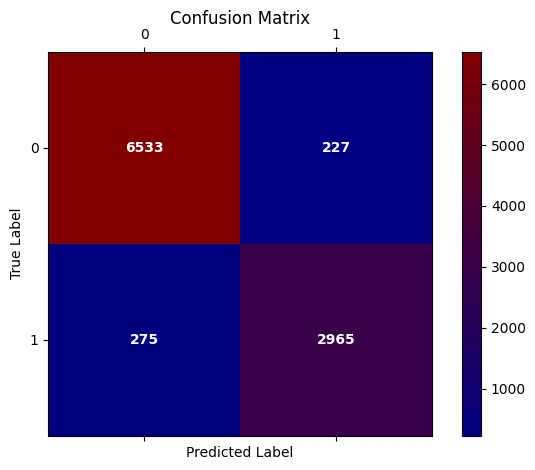

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


colors = ["#000080", "#800000"]  # dark blue to dark red
custom_cmap = LinearSegmentedColormap.from_list("blue_red", colors, N=256)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots()
im = ax.matshow(cm, cmap=custom_cmap)

# Add white text for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                va='center', ha='center',
                color='white', fontsize=10, fontweight='bold')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', pad=20)
plt.colorbar(im)
plt.tight_layout()
plt.show()


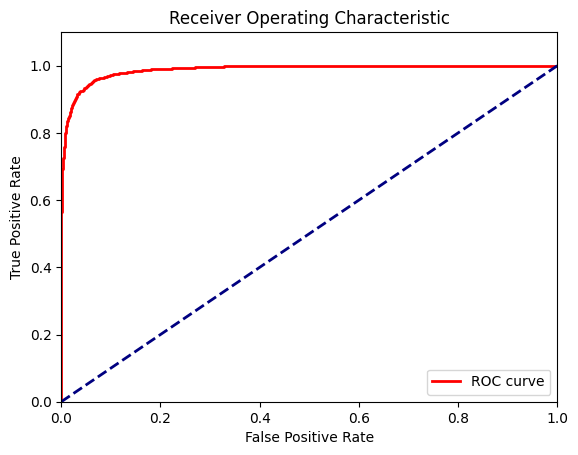

In [57]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])  # Prob for class 1
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="red", lw=2, label=f"ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [58]:
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'synfraud_model.pth')


torch.save(model.state_dict(), model_path)
print(f"\nModel saved to {model_path}")


Model saved to models\synfraud_model.pth
